In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import seaborn as sns

def modified_f1_score(labels, predictions):
    scores = []

    # For 1 vs. 0, exclude class 2 and consider only 1 and 0 for binary comparison
    mask_1_vs_0 = (labels != 2)
    labels_1_vs_0 = labels[mask_1_vs_0] == 1
    predictions_1_vs_0 = predictions[mask_1_vs_0] == 1
    if np.any(labels_1_vs_0) or np.any(predictions_1_vs_0):
        f1_1_vs_0 = f1_score(labels_1_vs_0, predictions_1_vs_0, pos_label=True, average='binary')
        scores.append(f1_1_vs_0)

    # For 2 vs. 0, exclude class 1 and consider only 2 and 0 for binary comparison
    mask_2_vs_0 = (labels != 1)
    labels_2_vs_0 = labels[mask_2_vs_0] == 2
    predictions_2_vs_0 = predictions[mask_2_vs_0] == 2
    if np.any(labels_2_vs_0) or np.any(predictions_2_vs_0):
        f1_2_vs_0 = f1_score(labels_2_vs_0, predictions_2_vs_0, pos_label=True, average='binary')
        scores.append(f1_2_vs_0)

    # Calculate the mean of the F1 scores if any valid scores were calculated
    mean_f1 = np.mean(scores) if scores else 0.0

    return f1_1_vs_0, f1_2_vs_0, mean_f1

In [2]:
data_path_real = '/content/drive/MyDrive/Colab_Notebooks/dye_test_opt/ternary/results/test_results_real_only.csv'
data_path_hybrid = '/content/drive/MyDrive/Colab_Notebooks/dye_test_opt/ternary/results/test_results.csv'
data_real = pd.read_csv(data_path_real)
data_hybrid = pd.read_csv(data_path_hybrid)

Must check binary versus macro diffs

In [3]:
months = ['may','july','october']
datasets = {'real':data_real, 'hybrid':data_hybrid}

results = []

for focal_data in ['real', 'hybrid']:
  data = datasets[focal_data]
  for month in months:
    focal_month = data[data['month'] == month]
    present_data = focal_month[focal_month['label'] != 0]
    absent_data = focal_month[focal_month['label'] == 0]

    # Iterating over all combinations of color, concentration, and size in present data

    for concentration in present_data['concentration'].unique():
        for size in present_data['size'].unique():

            # Subsetting present data for the specific combination
            present_subset = present_data[
                (present_data['concentration'] == concentration) &
                (present_data['size'] == size)
            ]

            # Combining with absent data
            combined_data = pd.concat([present_subset, absent_data])

            # Labels and predictions (assuming all present data as 'positive' and absent as 'negative')
            labels = combined_data['label']
            predictions = combined_data['pred']

            # Computing F1 score
            blue, red, mean = modified_f1_score(labels, predictions)
            # Appending the results

            if focal_data == 'real':
                results.append({
                    'month': month,
                    'color': 'blue',
                    'concentration': concentration,
                    'size': size,
                    'f1_score': blue
                })
            else:
                results.append({
                    'month': month,
                    'color': 'red',
                    'concentration': concentration,
                    'size': size,
                    'f1_score': red
                })

results_df = pd.DataFrame(results)

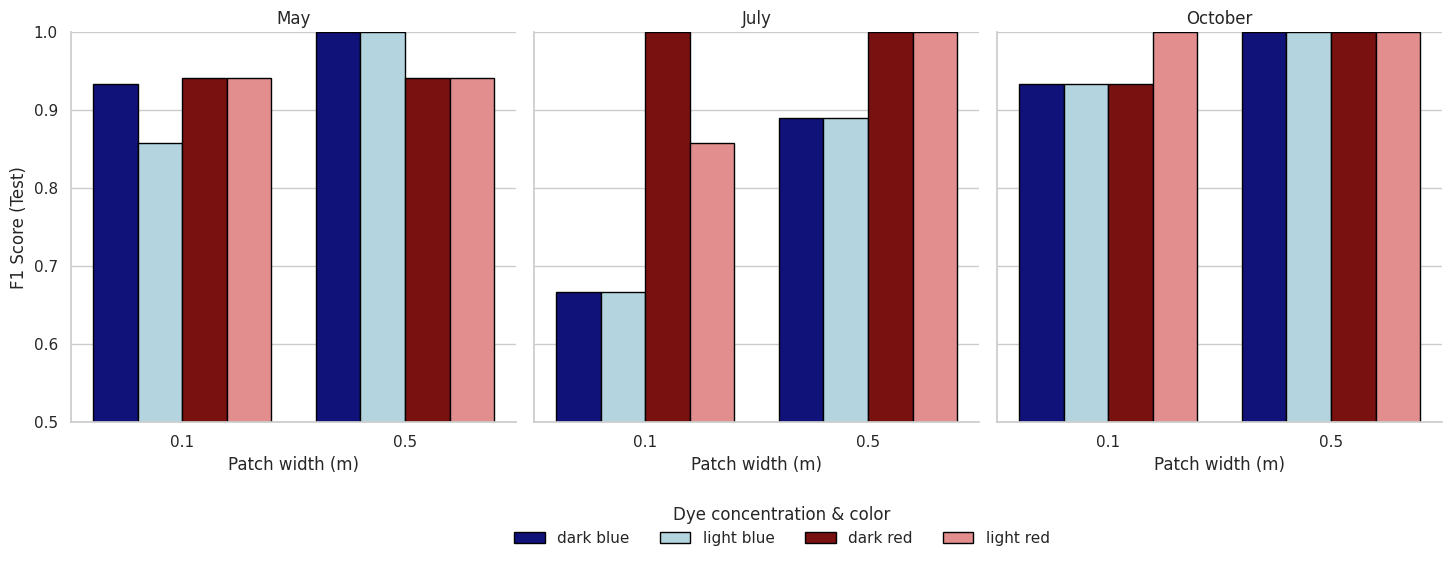

In [4]:
results_df['color_concentration'] = results_df.apply(lambda row: f"light {row['color']}" if row['concentration'] == 'low' else f"dark {row['color']}", axis=1)
color_concentration_order = ['dark blue', 'light blue', 'dark red', 'light red']
results_df['color_concentration'] = pd.Categorical(results_df['color_concentration'], categories=color_concentration_order, ordered=True)
results_df['month'] = results_df['month'].str.title()
# Set the seaborn style
sns.set(style="whitegrid")

# Create a FacetGrid, mapping the 'month' to the columns of the grid
g = sns.FacetGrid(results_df, col="month", height=5, aspect=1, col_order=['May', 'July', 'October'])

# Define a custom palette
custom_palette = {'light blue': '#add8e6', 'dark blue': '#00008b', 'light red': '#f08080', 'dark red': '#8b0000'}


# Map the barplot to each facet with specified order for 'hue'
g.map_dataframe(sns.barplot, x='size', y='f1_score', hue='color_concentration', hue_order=color_concentration_order,
                palette=custom_palette, dodge=True, edgecolor='black', linewidth=1)

# Set titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Patch width (m)", "F1 Score (Test)")

# Here we specify the minimum y-axis value
g.set(ylim=(0.5, 1.0))

# Add a legend outside the plot at the lower center
g.add_legend(title='Dye concentration & color', bbox_to_anchor=(0.4, 0), loc='upper center',
             ncol=4, fancybox=True, shadow=True)

plt.show()

In [5]:
results_df

,month,color,concentration,size,f1_score,color_concentration
0,May,blue,low,0.5,1.000000,light blue
1,May,blue,low,0.1,0.857143,light blue
2,May,blue,high,0.5,1.000000,dark blue
3,May,blue,high,0.1,0.933333,dark blue
4,July,blue,low,0.5,0.888889,light blue
5,July,blue,low,0.1,0.666667,light blue
6,July,blue,high,0.5,0.888889,dark blue
7,July,blue,high,0.1,0.666667,dark blue
8,October,blue,low,0.5,1.000000,light blue
9,October,blue,low,0.1,0.933333,light blue
